In [1]:
import matplotlib
matplotlib.use('Agg')
# Remove padding around screen
%matplotlib inline

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np

from os import walk
import tensorflow as tf,numpy,keras,PIL
from PIL import Image

import sys
from os.path import dirname
sys.path.append("/home/jason/sproj/donkeycar")

import donkeycar as dk
import donkeycar.parts.datastore as datastore

import keras

import donkeycar as dk
#import parts
from donkeycar.parts.camera import PiCamera
from donkeycar.parts.transform import Lambda
from donkeycar.parts.keras import KerasCategorical, KerasRNN_LSTM, KerasRNN_Categorical, KerasHresCategorical, KerasLinear

from vis.visualization import visualize_saliency, visualize_cam
from vis.utils import utils
from keras import activations

sys.path.insert(0, "/home/jason/sproj/scripts/")
from training_simulator import DataLoader



/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using donkey v2.2.1 ...


Using TensorFlow backend.


In [3]:
'''kl = KerasLinear()
kl.load('/home/jason/sproj/d2/models/linear/linear_8track2')

'''
def load_image(infilename):
    size = 160,120
    img = Image.open(infilename)
    img.thumbnail(size, Image.ANTIALIAS)
    data = numpy.asarray(img,dtype="uint8")
    return data

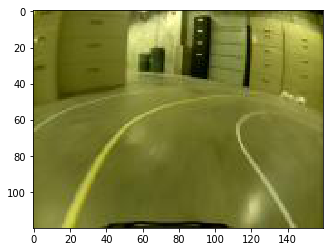

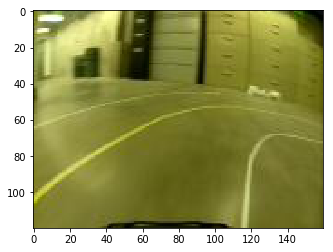

In [4]:
index = 730

fname = '/home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04/'+str(index)+'_cam-image_array_.jpg'
fname2 = '/home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04/'+str(index+10)+'_cam-image_array_.jpg'
x_test = load_image(fname)
x_test2 = load_image(fname2)
orig_img = plt.imshow(x_test)
plt.show()
orig_img = plt.imshow(x_test2)
plt.show()

In [7]:
track8 = datastore.Tub("/home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04/")

path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04/
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04/


In [6]:
track8.get_record(index)

{'cam/image_array': array([[[205, 208, 105],
         [131, 133,  32],
         [103, 105,   8],
         ...,
         [  9,   9,   0],
         [  5,   5,   0],
         [  5,   4,   0]],
 
        [[181, 184,  81],
         [123, 125,  24],
         [102, 104,   7],
         ...,
         [ 15,  17,   0],
         [ 10,  11,   0],
         [  1,   2,   0]],
 
        [[145, 148,  45],
         [114, 116,  15],
         [107, 109,  12],
         ...,
         [ 37,  41,   4],
         [ 36,  40,   5],
         [ 17,  21,   0]],
 
        ...,
 
        [[124, 127,  48],
         [126, 129,  50],
         [129, 132,  53],
         ...,
         [ 96,  98,  23],
         [ 91,  94,  17],
         [ 84,  87,  10]],
 
        [[123, 126,  47],
         [125, 128,  49],
         [128, 131,  52],
         ...,
         [ 95,  97,  22],
         [ 90,  93,  16],
         [ 84,  87,  10]],
 
        [[122, 125,  46],
         [124, 127,  48],
         [128, 131,  52],
         ...,
         

<Figure size 600x400 with 0 Axes>

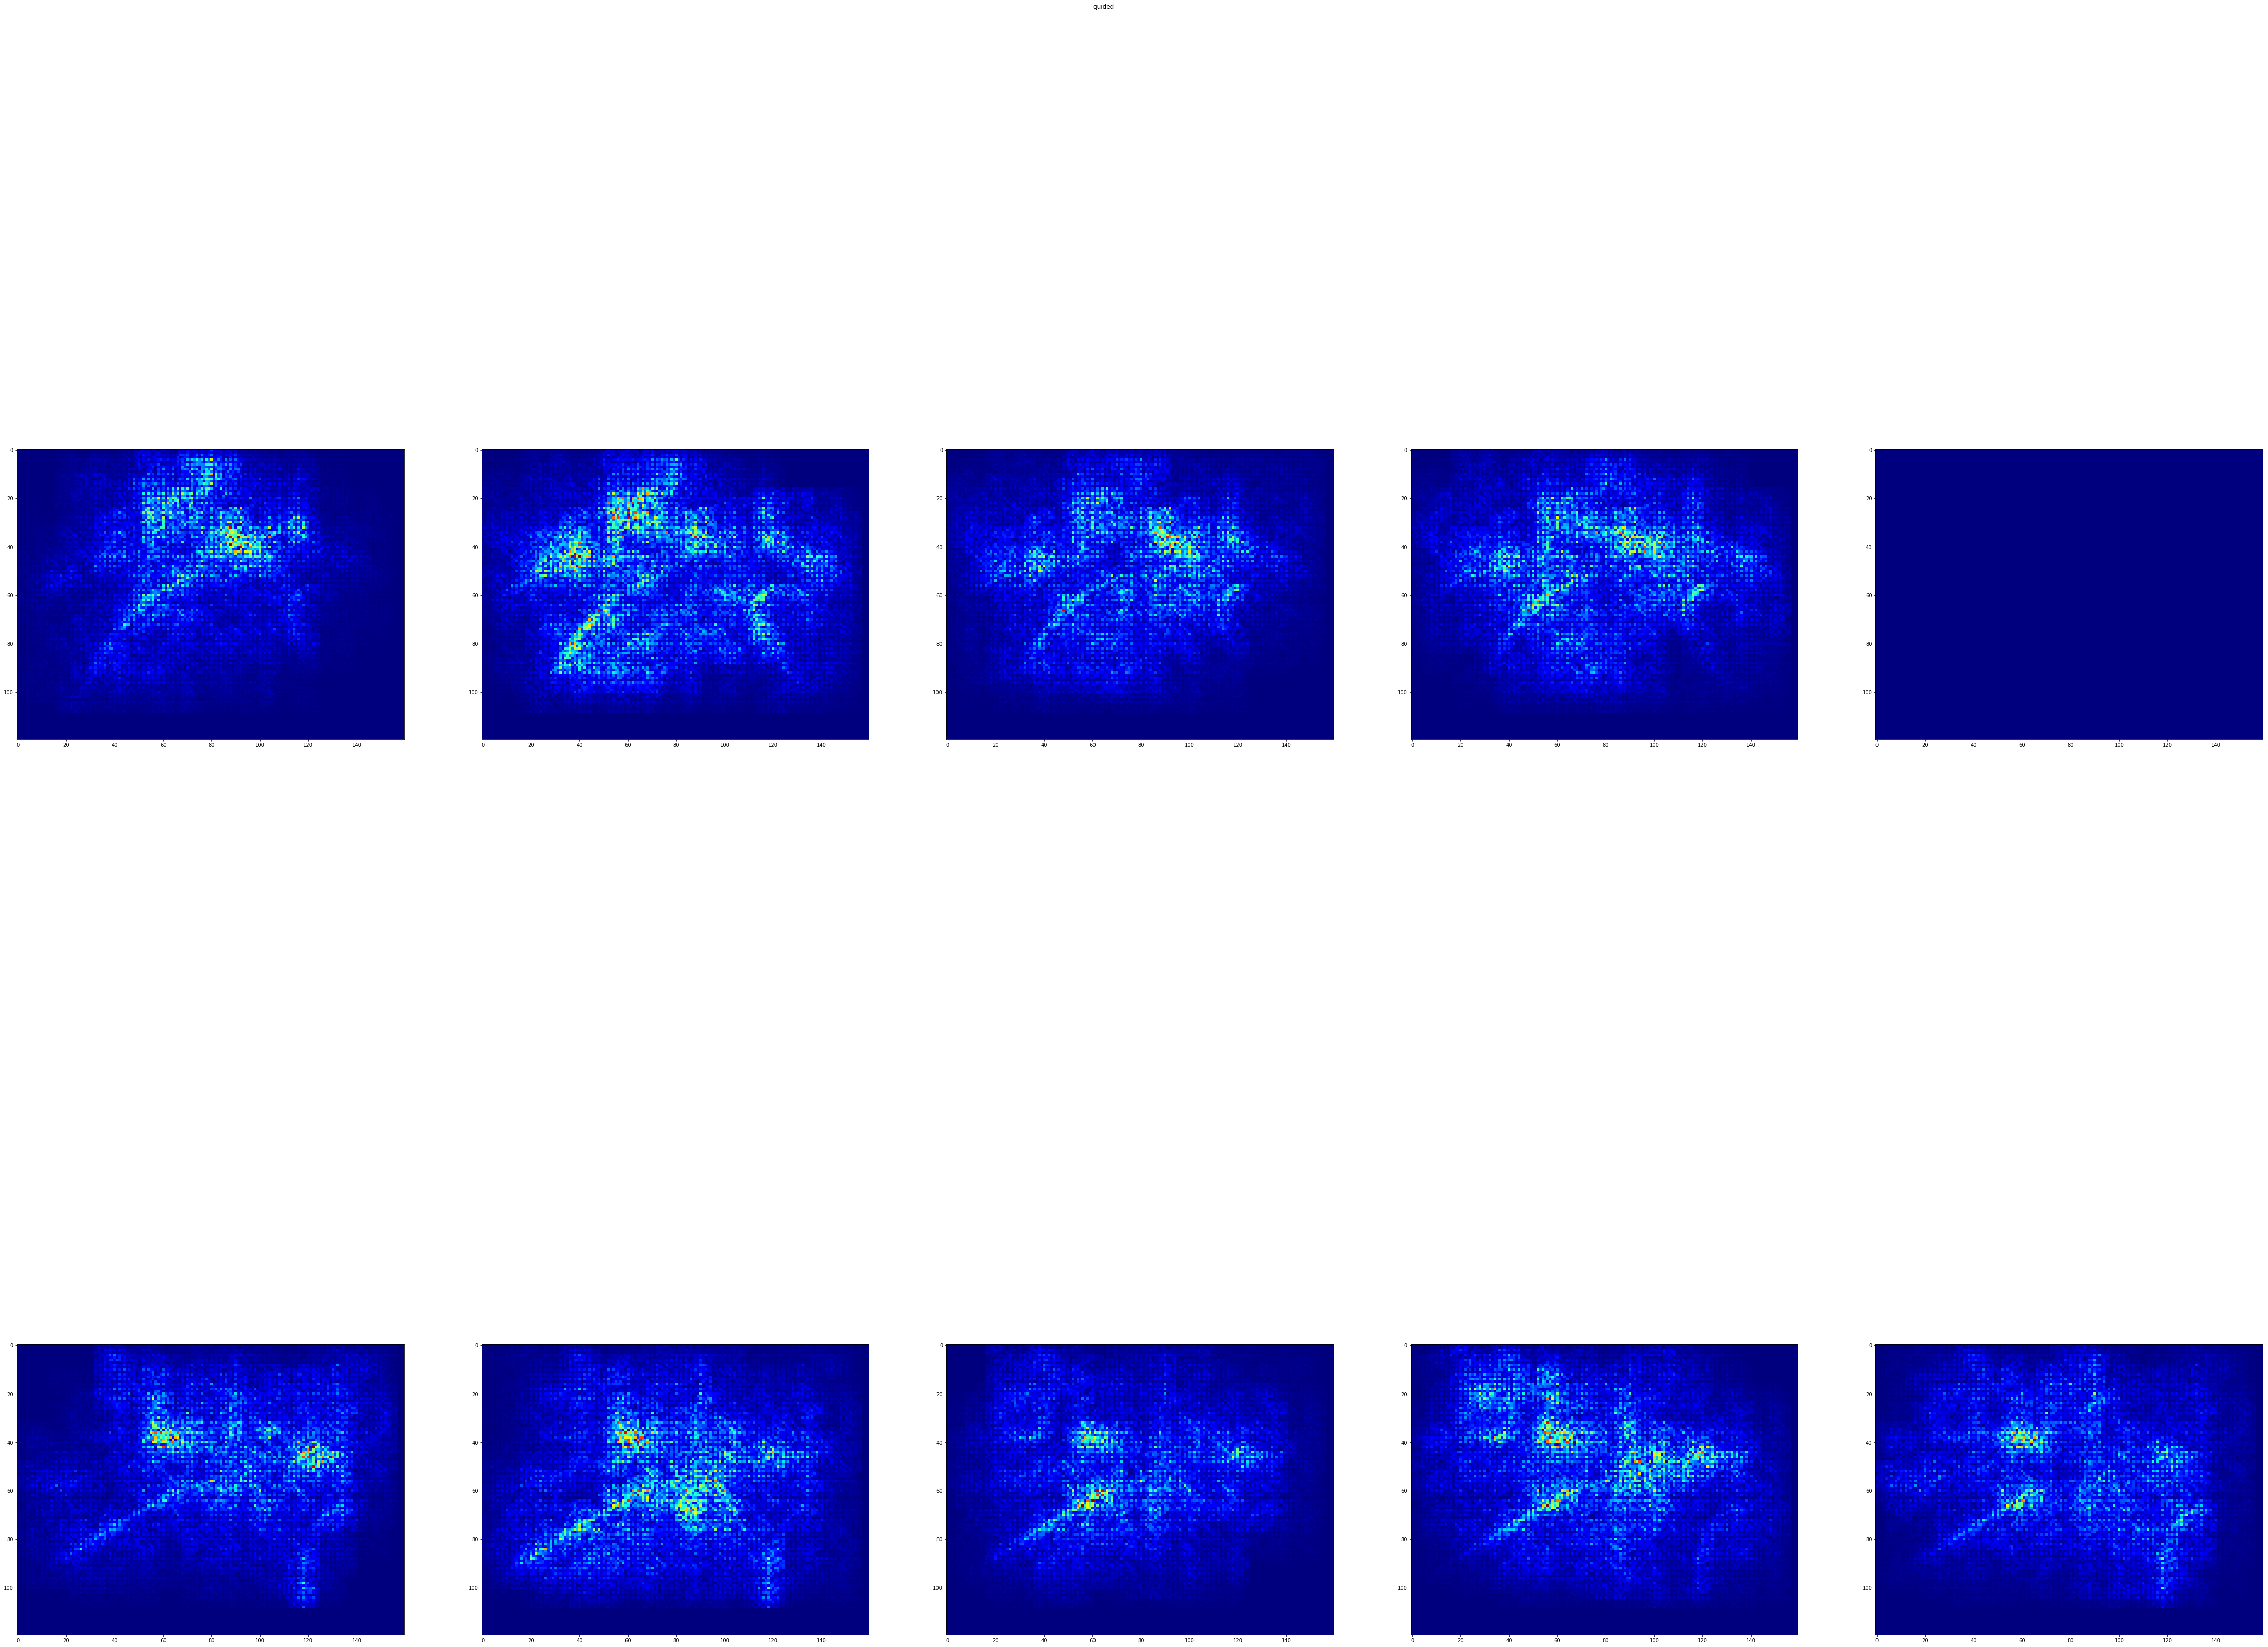

In [4]:
layer_idx = 7
for modifier in ['guided']:
    plt.figure(dpi=100)
    f, ax = plt.subplots(2, 5,figsize=(80,60))
    
    plt.suptitle(modifier)
    for i, img in enumerate([x_test,x_test2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        for x in range(5):
            grads = visualize_saliency(kl.model, layer_idx, filter_indices=x, 
                                       seed_input=img, backprop_modifier=modifier)
            # Lets overlay the heatmap onto original image.    
            ax[i][x].imshow(grads, cmap='jet')

(120, 160, 3)
(120, 160, 3)
(120, 160, 3)
(120, 160, 3)
(120, 160, 3)
(120, 160, 3)


<Figure size 432x288 with 0 Axes>

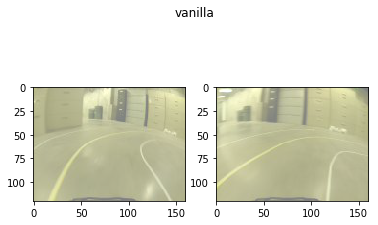

<Figure size 432x288 with 0 Axes>

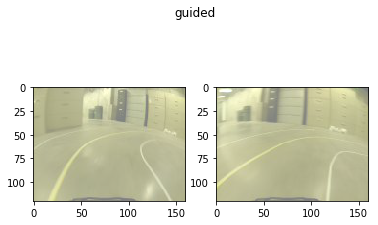

<Figure size 432x288 with 0 Axes>

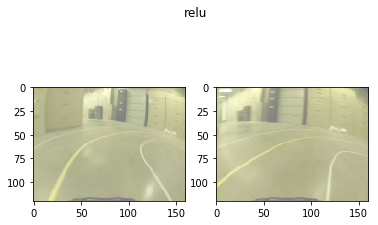

In [176]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([x_test,x_test2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(kl.model, layer_idx, filter_indices=20, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[...,3] * 255)
        print(jet_heatmap.shape)
        ax[i].imshow(overlay(jet_heatmap, img))

In [ ]:
class_idx = 0

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(kl.model, 'angle_out')

# Swap softmax with linear
kl.model.layers[layer_idx].activation = activations.linear
kl.model = utils.apply_modifications(kl.model)

grads = visualize_saliency(kl.model, layer_idx, filter_indices=class_idx, seed_input=x_test)


# Plot with 'jet' colormap to visualize as a heatmap.
img = plt.imshow(grads, cmap='jet')
plt.show()

In [ ]:
grads = visualize_saliency(kl.model, layer_idx, filter_indices=class_idx, seed_input=x_test, 
                           backprop_modifier='relu', grad_modifier='negate')
plt.imshow(grads, cmap='jet')